# Practica 3
### Integrantes:
- Arteaga Gonzalez Edwin Yahir
- Juárez Gaona Erick Rafael.
- Rico Gaytán Diana Andrea.
- Ruiz Merino Wendy Ivonne.


### Grupo: 6AV1
### Materia: Series de tiempo
### Fecha: 09/03/2025




## Introducción

El Sistema de Transporte Colectivo (STC) Metro de la Ciudad de México es uno de los principales medios de transporte en la ciudad, movilizando a millones de usuarios diariamente. La Línea 1, una de las más antiguas y transitadas, conecta diversas zonas importantes de la capital. El análisis de la afluencia en esta línea permite identificar patrones de movilidad, predecir la demanda y tomar decisiones informadas para la optimización del servicio.

## Problemática

La variación en la afluencia de pasajeros a lo largo del tiempo es un fenómeno complejo influenciado por múltiples factores, como eventos sociales, económicos, días festivos y otros factores estacionales. La predicción precisa de la afluencia diaria es crucial para una mejor planificación de recursos y logística del servicio.

## Cargar librerias

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [ ]:
df = pd.read_csv('afluenciastc_simple_01_2024.csv')
df = df[df["linea"] == "Linea 1"]
df = df[["fecha", "afluencia"]].groupby(["fecha"]).sum().reset_index()
df = df.rename(columns={"fecha": "date", "afluencia": "data"})

df["date"] = pd.to_datetime(df["date"])

df = df[(df["date"] >= "2010-01-01") & (df["date"] <= "2012-12-31")].reset_index()
df

,index,date,data
0,0,2010-01-01,251474
1,1,2010-01-02,511103
2,2,2010-01-03,423407
3,3,2010-01-04,769747
4,4,2010-01-05,733953
...,...,...,...
1091,1091,2012-12-27,690828
1092,1092,2012-12-28,711730
1093,1093,2012-12-29,635673
1094,1094,2012-12-30,489485


## Graficacion de los datos

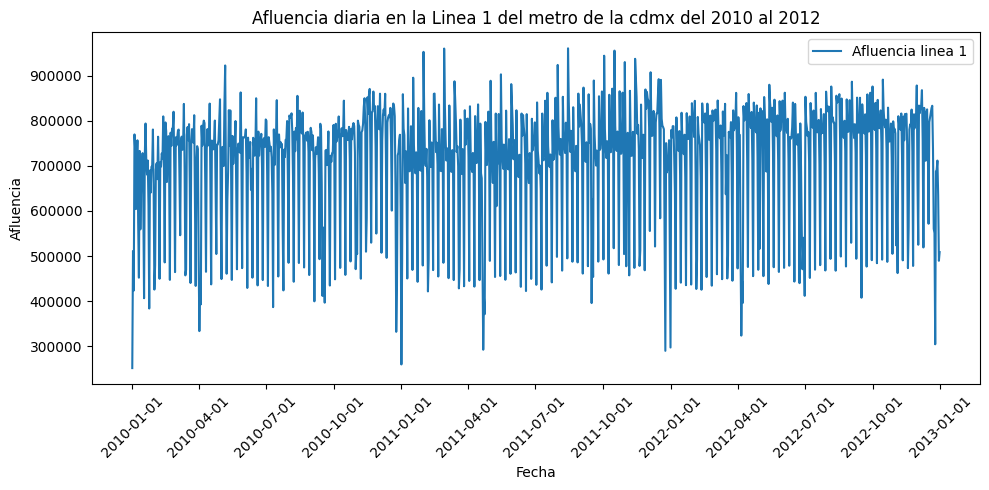

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["data"], label="Afluencia linea 1")
plt.title("Afluencia diaria en la Linea 1 del metro de la cdmx del 2010 al 2012")
plt.xlabel("Fecha")
plt.ylabel("Afluencia")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato Año-Mes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)  # Rotar etiquetas
plt.tight_layout()
plt.legend()
plt.show()



## Verificación de estacionalidad

In [ ]:
ADF_result = adfuller(df["data"])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.478887687720988
p-value: 2.308196281677974e-06


Por lo tanto es estacionario.


## Dividir en Test y Train

In [ ]:
df = pd.DataFrame({'date': df['date'][:], 'data': df['data']})
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date', inplace=True)
df

,data
date,
2010-01-01,251474
2010-01-02,511103
2010-01-03,423407
2010-01-04,769747
2010-01-05,733953
...,...
2012-12-27,690828
2012-12-28,711730
2012-12-29,635673


In [ ]:
train_df=df[:-10]
test_df=df[-10:]

### Modelo Regresion Lineal

In [ ]:
X = sm.add_constant(range(len(train_df)))
y = train_df['data']


modelo_rl = sm.OLS(y, X).fit()


predicciones = modelo_rl.predict(X)


nuevo_X = sm.add_constant(range(len(train_df), len(train_df) + 10))
predicciones_futuras = modelo_rl.predict(nuevo_X)




In [ ]:

ultimo_mes = train_df.last('1M')  # Seleccionar los datos del último mes
predicciones_ultimo_mes = predicciones[-len(ultimo_mes):]  # Predicciones correspondientes al último mes


ultimo_ano = train_df.last('1Y')  # Seleccionar los datos del último año
predicciones_ultimo_ano = predicciones[-len(ultimo_ano):]  # Predicciones correspondientes al último año



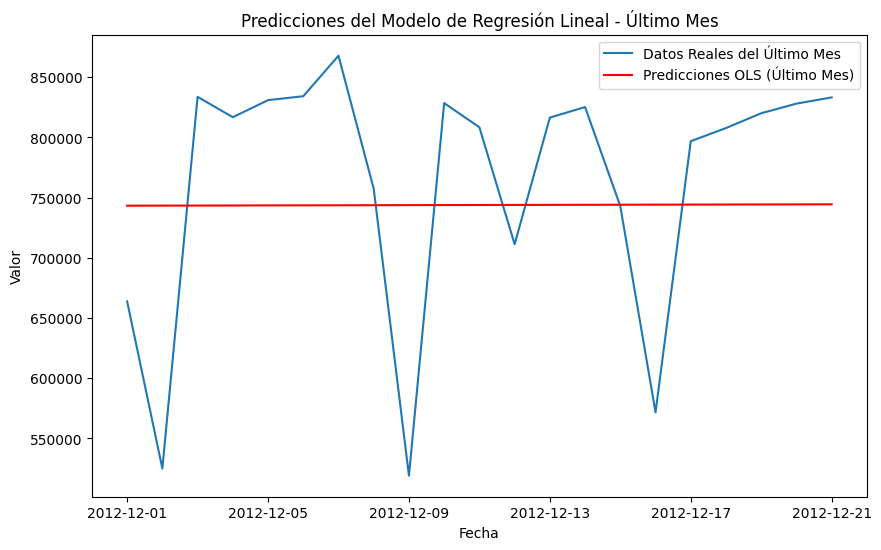

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(ultimo_mes.index, ultimo_mes['data'], label='Datos Reales del Último Mes')
plt.plot(ultimo_mes.index, predicciones_ultimo_mes, label='Predicciones OLS (Último Mes)', color='red')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones del Modelo de Regresión Lineal - Último Mes')
plt.show()

#

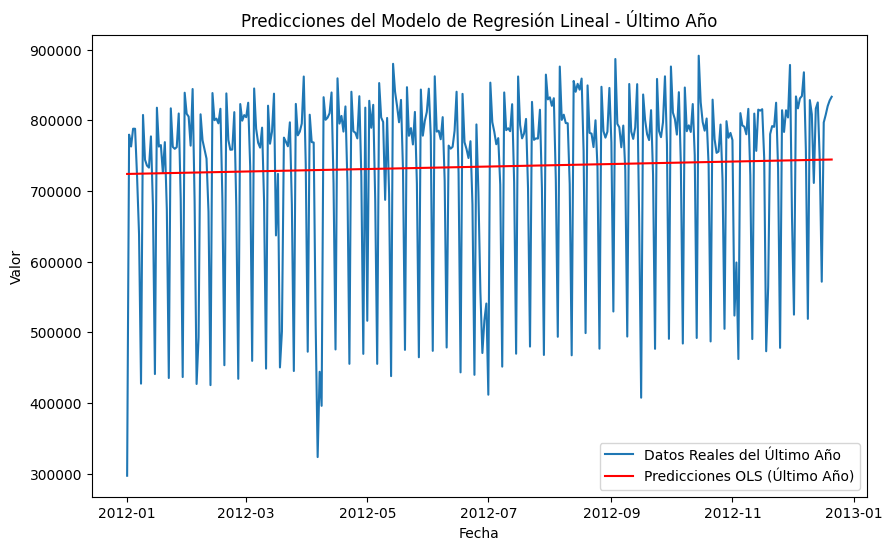

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ultimo_ano.index, ultimo_ano['data'], label='Datos Reales del Último Año')
plt.plot(ultimo_ano.index, predicciones_ultimo_ano, label='Predicciones OLS (Último Año)', color='red')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones del Modelo de Regresión Lineal - Último Año')
plt.show()

### Modelo ARIMA

In [ ]:
ps = range(0, 7,1)
qs = range(0, 7,1)
parameters = product(ps, qs)
parameters_list = list(parameters)

In [ ]:
def optimize_ARMA(endog, parameters_list):
  results = []
  for order in tqdm_notebook(parameters_list):
    try:
      model = SARIMAX(endog, order=(order[0],0,order[1]), simple_differencing=False).fit(disp=False)
    except:
      continue
    aic = model.aic
    results.append([order, aic])
    result_df =pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'aic']
    result_df = result_df.sort_values(by='aic', ascending=True).reset_index(drop=True)
  return result_df

In [ ]:
result = optimize_ARMA(df, parameters_list)

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
result

,"(p,q)",aic
0,"(6, 4)",22.000000
1,"(6, 6)",28379.225171
2,"(5, 6)",28415.470274
3,"(3, 6)",28605.147673
4,"(4, 6)",28621.520600
5,"(3, 5)",28647.699636
6,"(6, 5)",28684.314187
7,"(5, 5)",28699.067051
8,"(4, 4)",28699.372635
9,"(5, 4)",28707.109290


In [ ]:
model1 = SARIMAX(train_df["data"],order=(6,0,4), simple_differencing=False)
model_fit = model1.fit()

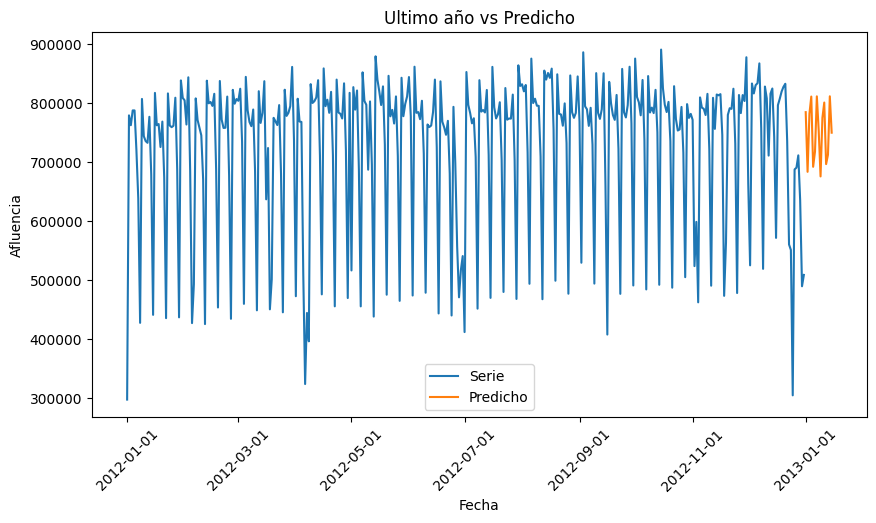

Error promedio absoluto: 161414.5891758614


In [ ]:
forecast_days = 15
forecast = model_fit.forecast(steps=forecast_days)
last_year = df.loc[df.index.year == df.index[-1].year]
last_month = last_year.loc[last_year.index.month == last_year.index[-1].month]
predicted_dates = pd.date_range(start=test_df.index[-1], periods=forecast_days+1, freq='D')[1:]
plt.figure(figsize=(10, 5))
plt.plot(last_year.index, last_year["data"], label="Serie")
plt.plot(predicted_dates, forecast, label="Predicho")
plt.title("Ultimo año vs Predicho")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Afluencia")
plt.legend()
plt.show()

mae = mean_absolute_error(test_df["data"], forecast[:len(test_df["data"])])
print(f"Error promedio absoluto: {mae}")

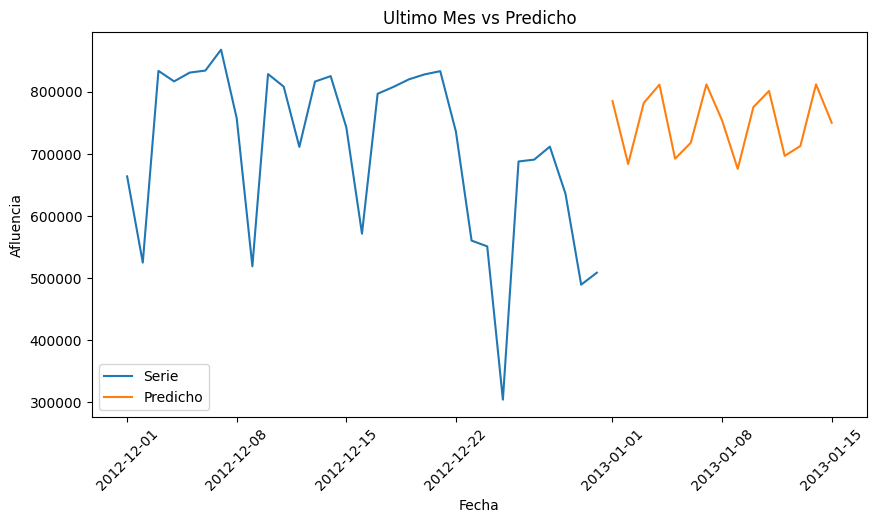

In [ ]:
forecast_days = 15
forecast = model_fit.forecast(steps=forecast_days)
last_year = df.loc[df.index.year == df.index[-1].year]
last_month = last_year.loc[last_year.index.month == last_year.index[-1].month]
predicted_dates = pd.date_range(start=test_df.index[-1], periods=forecast_days+1, freq='D')[1:]
plt.figure(figsize=(10, 5))
plt.plot(last_month.index, last_month["data"], label="Serie")
plt.plot(predicted_dates, forecast, label="Predicho")
plt.title("Ultimo Mes vs Predicho")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Afluencia")
plt.legend()
plt.show()


### Modelo SARIMAX

In [ ]:
def optimize_SARSMA(endog, parameters_list):
  results = []
  for order in tqdm_notebook(parameters_list):
    try:
      model = SARIMAX(endog, seasonal_order=(order[0],0,order[1],7), simple_differencing=False).fit(disp=False)
    except:
      continue
    aic = model.aic
    results.append([order, aic])
    result_df =pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'aic']
    result_df = result_df.sort_values(by='aic', ascending=True).reset_index(drop=True)
  return result_df

In [ ]:
model2 = SARIMAX(train_df["data"],seasonal_order=(6,0,4,7), simple_differencing=False)
model_fit_1 = model2.fit()

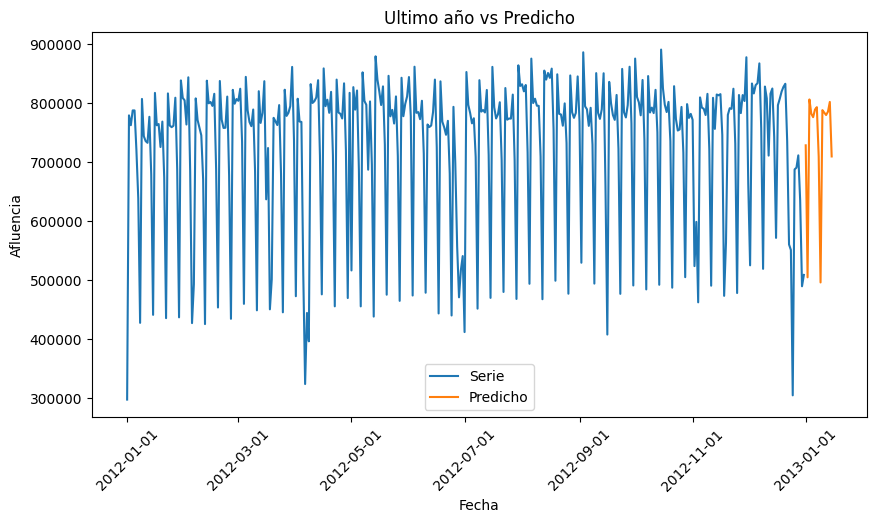

Error promedio absoluto: 142609.81846690603


In [ ]:
forecast_days = 15
forecast = model_fit_1.forecast(steps=forecast_days)
last_year = df.loc[df.index.year == df.index[-1].year]
last_month = last_year.loc[last_year.index.month == last_year.index[-1].month]
predicted_dates_s = pd.date_range(start=test_df.index[-1], periods=forecast_days+1, freq='D')[1:]
plt.figure(figsize=(10, 5))
plt.plot(last_year.index, last_year["data"], label="Serie")
plt.plot(predicted_dates_s, forecast, label="Predicho")
plt.title("Ultimo año vs Predicho")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Afluencia")
plt.legend()
plt.show()

mae = mean_absolute_error(test_df["data"], forecast[:len(test_df["data"])])
print(f"Error promedio absoluto: {mae}")

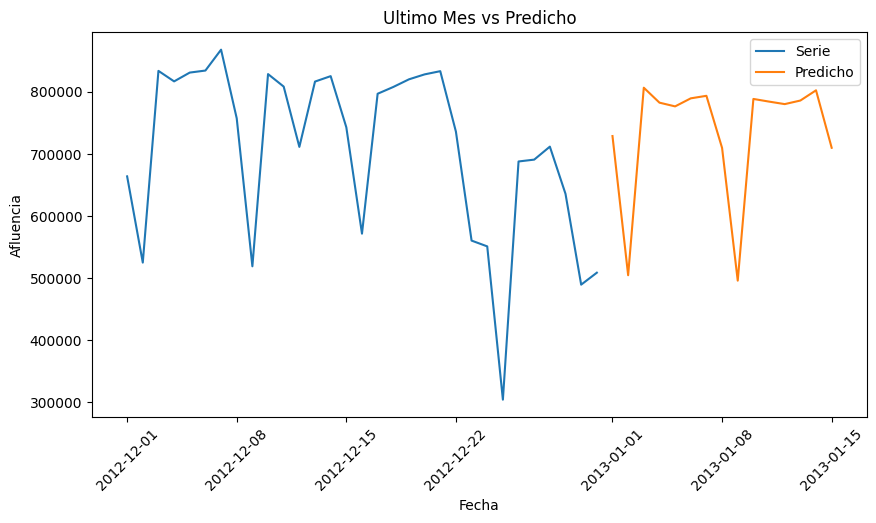

In [ ]:
forecast_days = 15
forecast = model_fit_1.forecast(steps=forecast_days)
last_year = df.loc[df.index.year == df.index[-1].year]
last_month = last_year.loc[last_year.index.month == last_year.index[-1].month]
predicted_dates_s = pd.date_range(start=test_df.index[-1], periods=forecast_days+1, freq='D')[1:]
plt.figure(figsize=(10, 5))
plt.plot(last_month.index, last_month["data"], label="Serie")
plt.plot(predicted_dates_s, forecast, label="Predicho")
plt.title("Ultimo Mes vs Predicho")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Afluencia")
plt.legend()
plt.show()